Este código implementa o algoritmo AutoCloud, uma abordagem baseada em aprendizado não supervisionado para a detecção de padrões e agrupamento de dados. Primeiro teste, dados nao rotulados

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from plotly.subplots import make_subplots
from plotly.offline import plot
import plotly.graph_objects as go
from scipy.spatial import cKDTree  # Para encontrar o centróide mais próximo


In [19]:
listaCor =np.array(['#4C72B0','#DD8452','#55A868','#C44E52','#8172B3','#937860','#DA8BC3','#8C8C8C','#CCB974','#64B5CD'])

In [20]:
class DataCloud:
	N=0 #Conta o número total de nuvens de dados criadas.
	def __init__(self,x): #É chamado quando uma nova instância de DataCloud é criada.
		self.n=1 #Inicializa o n de pontos na nuvem como 1, pois estamos adicionando o primeiro ponto x.
		self.mean=x #Inicializa a média da nuvem como o valor do primeiro ponto x. A média é o centro da nuvem.
		self.variance=0 #Inicializa a variância como 0, pois com apenas um ponto, não há dispersão.
		self.pertinency=1 #Inicializa o grau de pertinência como 1, indicando que o ponto pertence completamente à nuvem.
		DataCloud.N+=1 #Incrementa o contador de nuvens de dados criadas.
	def addDataClaud(self,x):
		self.n=2 #Define o n de pontos na nuvem como 2, assumindo que estamos adicionando um segundo ponto
		self.mean=(self.mean+x)/2 #Atualiza a média da nuvem. A nova média é a média aritmética entre a média anterior e o novo ponto x.
		self.variance=((np.linalg.norm(self.mean-x))**2) #Atualiza a variância da nuvem. A variância é calculada como o quadrado da distância entre a nova média e o novo ponto x.
	def updateDataCloud(self,n,mean,variance): #Este método atualiza os atributos da nuvem de dados com novos valores.
		self.n=n #Atualiza o número de pontos na nuvem.
		self.mean=mean #Atualiza a média da nuvem.
		self.variance=variance #Atualiza a variância da nuvem.


In [21]:
class AutoCloud:
	c= np.array([DataCloud(0)],dtype=DataCloud)
	alfa= np.array([0.0],dtype=float)
	intersection = np.zeros((1,1),dtype=int)
	listIntersection = np.zeros((1),dtype=int)
	matrixIntersection = np.zeros((1,1),dtype=int)
	relevanceList = np.zeros((1),dtype=int)
	k=1
	def __init__(self, m):
		AutoCloud.m = m
		AutoCloud.c= np.array([DataCloud(0)],dtype=DataCloud)
		AutoCloud.alfa= np.array([0.0],dtype=float)
		AutoCloud.intersection = np.zeros((1,1),dtype=int)
		AutoCloud.listIntersection = np.zeros((1),dtype=int)
		AutoCloud.relevanceList = np.zeros((1),dtype=int)
		AutoCloud.matrixIntersection = np.zeros((1,1),dtype=int)
		AutoCloud.classIndex = []
		AutoCloud.k = 1

	def mergeClouds(self):
		i=0
		while(i<len(AutoCloud.listIntersection)-1):
			merge=False
			j=i+1
			while(j<len(AutoCloud.listIntersection)):
				#print("i",i,"j",j,"l",np.size(AutoCloud.listIntersection),"m",np.size(AutoCloud.matrixIntersection),"c",np.size(AutoCloud.c))
				if(AutoCloud.listIntersection[i] == 1 and AutoCloud.listIntersection[j] == 1):
					AutoCloud.matrixIntersection[i,j] = AutoCloud.matrixIntersection[i,j] + 1;
				nI = AutoCloud.c[i].n
				nJ = AutoCloud.c[j].n
				meanI = AutoCloud.c[i].mean
				meanJ = AutoCloud.c[j].mean
				varianceI = AutoCloud.c[i].variance
				varianceJ = AutoCloud.c[j].variance
				nIntersc = AutoCloud.matrixIntersection[i,j]
				if (nIntersc > (nI - nIntersc) or nIntersc > (nJ - nIntersc)):
					print(f'na iteracao {self.k} houve fusao de clouds')
					merge = True
					#update values
					n = nI + nJ - nIntersc
					mean = ((nI * meanI) + (nJ * meanJ))/(nI + nJ)
					variance = ((nI - 1) * varianceI + (nJ - 1) * varianceJ)/(nI + nJ - 2)
					newCloud = DataCloud(mean)
					newCloud.updateDataCloud(n,mean,variance)
					#atualizando lista de interseção
					AutoCloud.listIntersection = np.concatenate((AutoCloud.listIntersection[0 : i], np.array([1]), AutoCloud.listIntersection[i + 1 : j],AutoCloud.listIntersection[j + 1 : np.size(AutoCloud.listIntersection)]),axis=None)
					#atualizando lista de data clouds
					AutoCloud.c = np.concatenate((AutoCloud.c[0 : i ], np.array([newCloud]), AutoCloud.c[i + 1 : j],AutoCloud.c[j + 1 : np.size(AutoCloud.c)]),axis=None)
					#update  intersection matrix
					M0 = AutoCloud.matrixIntersection
					#Remover linhas
					M1=np.concatenate((M0[0 : i , :],np.zeros((1,len(M0))),M0[i + 1 : j, :],M0[j + 1 : len(M0), :]))
					#remover colunas
					M1=np.concatenate((M1[:, 0 : i ],np.zeros((len(M1),1)),M1[:, i+1 : j],M1[:, j+1 : len(M0)]),axis=1)
					#calculando nova coluna
					col = (M0[:, i] + M0[:, j])*(M0[: , i]*M0[:, j] != 0)
					col = np.concatenate((col[0 : j], col[j + 1 : np.size(col)]))
					#calculando nova linha
					lin = (M0[i, :]+M0[j, :])*(M0[i, :]*M0[j, :] != 0)
					lin = np.concatenate((lin[ 0 : j], lin[j + 1 : np.size(lin)]))
					#atualizando coluna
					M1[:,i]=col
					#atualizando linha
					M1[i,:]=lin
					M1[i, i + 1 : j] = M0[i, i + 1 : j] + M0[i + 1 : j, j].T;
					AutoCloud.matrixIntersection = M1
				j += 1
			if(merge):
				i = 0
			else:
				i += 1

	def run(self,X):
		AutoCloud.listIntersection = np.zeros((np.size(AutoCloud.c)),dtype=int)
		if AutoCloud.k==1:
			AutoCloud.c[0]=DataCloud(X)
			AutoCloud.classIndex.append(0)
		elif AutoCloud.k==2:
			AutoCloud.c[0].addDataClaud(X)
			AutoCloud.classIndex.append(0)
		elif AutoCloud.k>=3:
			i=0
			createCloud = True
			AutoCloud.alfa = np.zeros((np.size(AutoCloud.c)),dtype=float)
			for data in AutoCloud.c:
				n= data.n +1
				mean = ((n-1)/n)*data.mean + (1/n)*X
				variance = ((n-1)/n)*data.variance +(1/n)*((np.linalg.norm(X-mean))**2)
				if variance == 0:
					eccentricity = 0
				else:
					eccentricity = (1/n)+((mean-X).T.dot(mean-X))/(n*variance)
				typicality = 1 - eccentricity
				norm_eccentricity = eccentricity/2
				norm_typicality = typicality/(AutoCloud.k-2)
				data.eccAn = eccentricity
				#print('tiṕicidade normalizada',norm_typicality)
				if(norm_eccentricity<=(AutoCloud.m**2 +1)/(2*n)):
					#print('dentro do limiar. tipicidade normalizada:',norm_typicality)
					data.updateDataCloud(n,mean,variance)
					AutoCloud.alfa[i] = norm_typicality
					createCloud= False
					AutoCloud.listIntersection[i] = 1
				else:
					AutoCloud.alfa[i] = 0
					AutoCloud.listIntersection[i] = 0
				i+=1
				
			if(createCloud):
				AutoCloud.c = np.append(AutoCloud.c,DataCloud(X))
				AutoCloud.listIntersection = np.insert(AutoCloud.listIntersection,i,1)
				AutoCloud.matrixIntersection = np.pad(AutoCloud.matrixIntersection, ((0,1),(0,1)), 'constant', constant_values=(0))
			self.mergeClouds()
			#print('AutoCloud.alfa:', AutoCloud.alfa)
			if np.sum(AutoCloud.alfa) >0:
				AutoCloud.relevanceList = AutoCloud.alfa /np.sum(AutoCloud.alfa)
			if np.sum(AutoCloud.alfa) == 0:
				AutoCloud.relevanceList = AutoCloud.alfa /np.inf
			classIndex = np.argmax(AutoCloud.relevanceList)
			AutoCloud.classIndex.append(classIndex)


		AutoCloud.k=AutoCloud.k+1


#Carregamento e Pré-processamento de Dados

In [22]:

df = pd.read_csv('[coleta 2] captura_pacotes.csv', sep=',') #Selecionar colunas relevantes
#df_reduzido = df.iloc[::4, :] #Selecionar apenas uma a cada quatro amostras
df = df.fillna(0) #Substituir valores NaN por zero em todo o dataframe

f1 = df['TCP Len'].values
f2 = df['MQTT Len'].values
f3 = df['TCP Time Delta'].values

df2= pd.DataFrame(np.array([f1,f2,f3])).T
dados = np.array([f1,f2,f3]).T
print(f"Total de amostras no array 'dados': {dados.shape}")


Total de amostras no array 'dados': (88113, 3)


#Teste de verificação das cloud, processa uma amostra por vez. Se nao precisar analisar amostrar por amostra nao precisa usar as cedulas a seguir:

In [23]:
i = 0
teste=AutoCloud(1.8)

In [24]:
dados

array([[0.0000e+00, 0.0000e+00, 0.0000e+00],
       [0.0000e+00, 0.0000e+00, 1.6736e-05],
       [0.0000e+00, 0.0000e+00, 0.0000e+00],
       ...,
       [2.8960e+03, 0.0000e+00, 1.0000e-08],
       [0.0000e+00, 0.0000e+00, 3.9940e-06],
       [2.8960e+03, 0.0000e+00, 1.5000e-08]], shape=(88113, 3))

In [25]:
print('iteration:',i+1,'x:',dados[i])
teste.run(np.array(dados[i]))
i = i + 1
print('----------------------------------')
for j,cloud in enumerate(teste.c,start=0):
    print(f'cloud numero {j+1}')
    print('n:',cloud.n,'mean:',cloud.mean,'variance:',cloud.variance)
    print('+++++++++++++++++++++++++++++++')


iteration: 1 x: [0. 0. 0.]
----------------------------------
cloud numero 1
n: 1 mean: [0. 0. 0.] variance: 0
+++++++++++++++++++++++++++++++


##Teste do parâmetro m, que define a tolerância para a criação de novas nuvens.

In [26]:
x = np.arange(1,100)
def limiar(m,x):
    return (1+m**2)/(2*x)
ms = np.array([1.25,1.5,2])
labels = [f'm:{ms[i-1]}' for i in range(1,1+len(ms))]
'''plt.figure(figsize=(10,5))
for m,label in zip(ms,labels):
    plt.plot(x,limiar(m,x),label=label)
xticks = list(np.arange(0,31))
yticks = list(np.arange(0,1.75,0.125))
plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('quantidade de dados')
plt.ylabel('valores de m')
plt.grid(True)
plt.legend()'''

fig = make_subplots(rows=1, cols=1)
for m,label in zip(ms[:],labels[:]):
    fig.add_trace(go.Scatter(x=x,y=limiar(m,x),name=label),row=1,col=1)
fig.update_layout(width=800, height=500, title=f'análise dos valores de m')
fig.update_yaxes(title_text = f'valor de m{m}')
fig.update_xaxes(title_text = 'quatidade de dados')
fig.show()

#Teste para o AutoCloud para processar todas as amostras de uma vez e gerar o grafico

In [27]:
teste=AutoCloud(1.8) # valor do parametro m
j= 88000 #Define a quantidade de amostras serão usadas
for dado in dados[:j]:
    teste.run(np.array(dado))
print('--------------------------------')
for k,cloud in enumerate(teste.c,start=0):
    print(f'cloud numero {k+1}')
    print('n:',cloud.n,'mean:',cloud.mean,'variance:',cloud.variance)
    print('+++++++++++++++++++++++++++++++')


na iteracao 85 houve fusao de clouds
na iteracao 93 houve fusao de clouds
na iteracao 308 houve fusao de clouds
na iteracao 471 houve fusao de clouds
na iteracao 657 houve fusao de clouds
na iteracao 1376 houve fusao de clouds
na iteracao 1449 houve fusao de clouds
na iteracao 1872 houve fusao de clouds
na iteracao 3221 houve fusao de clouds
na iteracao 3704 houve fusao de clouds
na iteracao 3769 houve fusao de clouds
na iteracao 4196 houve fusao de clouds
na iteracao 4712 houve fusao de clouds
na iteracao 5668 houve fusao de clouds
na iteracao 6048 houve fusao de clouds
na iteracao 6340 houve fusao de clouds
na iteracao 6378 houve fusao de clouds
na iteracao 6455 houve fusao de clouds
na iteracao 6919 houve fusao de clouds
na iteracao 6987 houve fusao de clouds
na iteracao 7364 houve fusao de clouds
na iteracao 7368 houve fusao de clouds
na iteracao 7741 houve fusao de clouds
na iteracao 7755 houve fusao de clouds
na iteracao 8198 houve fusao de clouds
na iteracao 8249 houve fusao de 

/tmp/ipykernel_8885/2247420822.py:9: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



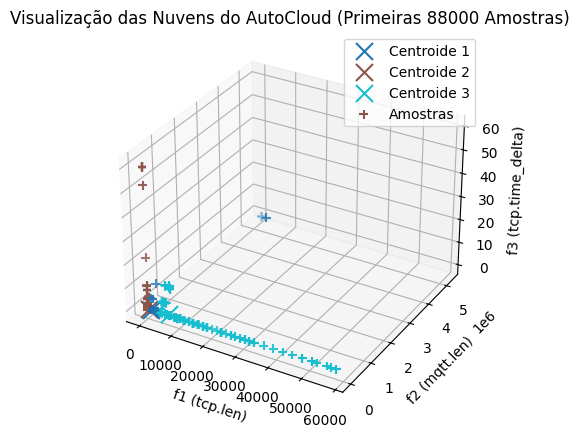

In [28]:

# Criar figura e eixos 3D
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')     

j = 88000 # Quantidade de amostras usadas

# Gerar cores únicas para cada centróide
num_centroides = len(teste.c)
cores_centroides = plt.cm.get_cmap("tab10", num_centroides)  # Escolher um mapa de cores

# Criar um array para armazenar as cores dos centroides
centroides = np.array([cloud.mean[:3] for cloud in teste.c])  # Pegar apenas as 3 primeiras dimensões
cores = [cores_centroides(i) for i in range(num_centroides)]

# Criar KDTree para encontrar o centróide mais próximo de cada amostra
tree = cKDTree(centroides)
amostras = np.column_stack((f1[:j], f2[:j], f3[:j]))  # Criar matriz com as 3 primeiras features
distancias, indices = tree.query(amostras)  # Encontra o centróide mais próximo

# Plotar os centroides
for i, cloud in enumerate(teste.c):
    m = cloud.mean[:3]  # Usar apenas as 3 primeiras dimensões
    ax.scatter(m[0], m[1], m[2], marker='x', s=150, color=cores[i], label=f'Centroide {i+1}')

# Plotar as amostras com cores correspondentes aos centroides mais próximos
ax.scatter(f1[:j], f2[:j], f3[:j], c=[cores[i] for i in indices], marker='+', s=40, label='Amostras')

# Rótulos dos eixos
ax.set_xlabel('f1 (tcp.len)')
ax.set_ylabel('f2 (mqtt.len)')
ax.set_zlabel('f3 (tcp.time_delta)')

# Título e legenda
ax.set_title(f'Visualização das Nuvens do AutoCloud (Primeiras {j} Amostras)')
ax.legend(loc='upper right')

plt.show()

In [29]:
'''
# Criar figura e eixos 3D para ver centroides e clouds
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
j=88000 #Define a quantidade de amostras serão usadas
# Plotar os pontos

for cloud in teste.c:
    m = cloud.mean
    ax.scatter(m[0], m[1], m[2],  marker='o', s=40, label='Centroide')
ax.scatter(f1[0:j], f2[0:j], f3[0:j], c='red', marker='+', s=20, label='Pontos')

# Rótulos dos eixos
ax.set_xlabel('Eixo f1')
ax.set_ylabel('Eixo f2')
ax.set_zlabel('Eixo f3')

# Título e legenda
ax.set_title('Gráfico de Pontos 3D')
ax.legend('upper right')
plt.show()'
'''

"\n# Criar figura e eixos 3D para ver centroides e clouds\nfig = plt.figure(figsize=(5, 5))\nax = fig.add_subplot(111, projection='3d')\nj=88000 #Define a quantidade de amostras serão usadas\n# Plotar os pontos\n\nfor cloud in teste.c:\n    m = cloud.mean\n    ax.scatter(m[0], m[1], m[2],  marker='o', s=40, label='Centroide')\nax.scatter(f1[0:j], f2[0:j], f3[0:j], c='red', marker='+', s=20, label='Pontos')\n\n# Rótulos dos eixos\nax.set_xlabel('Eixo f1')\nax.set_ylabel('Eixo f2')\nax.set_zlabel('Eixo f3')\n\n# Título e legenda\nax.set_title('Gráfico de Pontos 3D')\nax.legend('upper right')\nplt.show()'\n"

     f1   f2        f3
0   0.0  0.0  0.000000
1   0.0  0.0  0.000017
2   0.0  0.0  0.000000
3   0.0  0.0  0.000015
4   0.0  0.0  0.000000
5   0.0  0.0  0.000009
6   0.0  0.0  0.000000
7   0.0  0.0  0.000007
8   0.0  0.0  0.000000
9   0.0  0.0  0.000007
10  0.0  0.0  0.000000
11  0.0  0.0  0.000006
12  0.0  0.0  0.000000
13  0.0  0.0  0.000007
14  0.0  0.0  0.000000
15  0.0  0.0  0.000010
16  0.0  0.0  0.000000
17  0.0  0.0  0.000006
18  0.0  0.0  0.000000
19  0.0  0.0  0.000006
20  0.0  0.0  0.000000
21  0.0  0.0  0.000009
22  0.0  0.0  0.000000
23  0.0  0.0  0.000003
24  0.0  0.0  0.000000


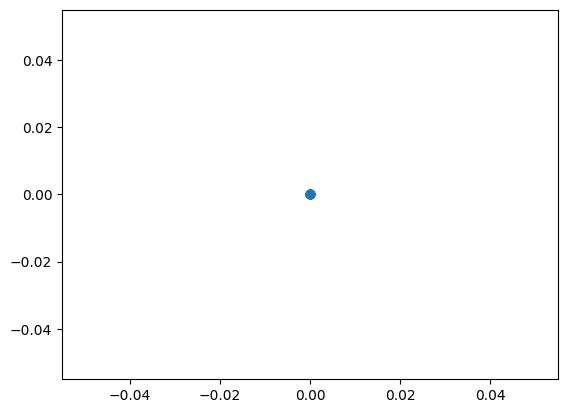

In [30]:
j=25 #Define a quantidade de amostras serão usadas
f = np.array([f1[:j],f2[:j],f3[:j]]).T
df_teste = pd.DataFrame(f)
df_teste.columns = ['f1','f2','f3',]
print(df_teste)
plt.scatter(f1[:j],f2[:j])

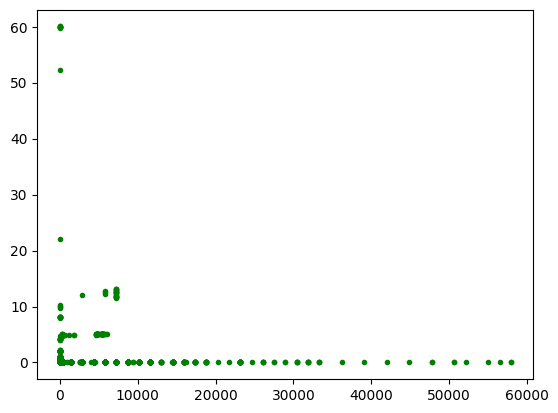

In [31]:
plt.plot(dados.T[0],dados.T[2],'.g')

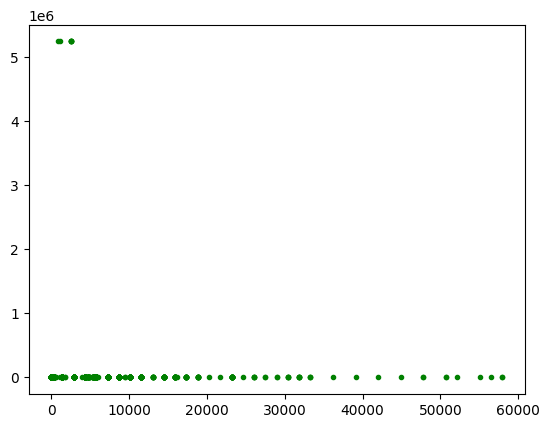

In [32]:
plt.plot(df['TCP Len'],df['MQTT Len'],'.g')

#Processa todas as amostras para o conjunto completo de dados

In [33]:
dados= dados.T
teste=AutoCloud(2)
for t in dados:
    teste.run(np.array(t))

In [34]:
dados

array([[0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 2.8960e+03, 0.0000e+00,
        2.8960e+03],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [0.0000e+00, 1.6736e-05, 0.0000e+00, ..., 1.0000e-08, 3.9940e-06,
        1.5000e-08]], shape=(3, 88113))